In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn
#from torchsummary import summary
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

import cv2

import os
import json

DataSet with Hand Gestures:
https://universe.roboflow.com/hand-gestures-recognition/hand-gestures-dataset

Набор данных представляет собой коллекцию фотографий жестов, сфотографиированных с web камеры

In [ ]:
!ls

In [ ]:
!wget -O dataset https://universe.roboflow.com/ds/KN0MHjXhiy?key=dui9XIg8M1

In [ ]:
!unzip -q dataset -d data

In [2]:
folder_path = './Hand gestures dataset.v7-complete_v2_416x416.createml/train/'
list_train_img_names = os.listdir(folder_path)

In [3]:
# Поиск json файла, содержащего информацию о обучающих данных
dict_img_codes = {}
name_json_file = ''

for name_str in list_train_img_names:
    #print(name_str.split('.')[-1])
    file_ext = name_str.split('.')[-1]
    if file_ext == 'json':
        name_json_file = name_str
    else:
        list_name_str = name_str.split('.')[:-1]
        img_key = '.'.join(name_str.split('.')[:-1])
        dict_img_codes[img_key] = [img_key + '.jpg',
                                img_key + '.txt']

In [4]:
train_annotation = pd.read_json(folder_path + name_json_file)
train_annotation.head(3)

,image,annotations
0,C-D_mp4-28_jpg.rf.7dd960bce8ba5e68dfd98ac1b76e...,"[{'label': 'C', 'coordinates': {'x': 106.5, 'y..."
1,C-L_mp4-1_jpg.rf.7de949af56e038846790642c28404...,"[{'label': 'C', 'coordinates': {'x': 127.5, 'y..."
2,D-R_mp4-28_jpg.rf.7deb2e3f834735f434d44839ad94...,"[{'label': 'D', 'coordinates': {'x': 293.5, 'y..."


In [5]:
# Редактирование данных
train_annotation['label'] = train_annotation['annotations'].apply(lambda x: x[0]['label'])
train_annotation['xc'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['x'])
train_annotation['yc'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['y'])
train_annotation['width'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['width'])
train_annotation['height'] = train_annotation['annotations'].apply(lambda x: x[0]['coordinates']['height'])

In [6]:
train_annotation.drop(columns=['annotations'], inplace=True)

In [7]:
train_annotation = train_annotation.astype({'xc': 'float', 'yc': 'float', 
                                            'width': 'float', 'height': 'float'})

In [8]:
train_annotation['xmin'] = (train_annotation['xc'] - train_annotation['width'] / 2)
train_annotation['xmax'] = (train_annotation['xc'] + train_annotation['width'] / 2)

train_annotation['ymin'] = (train_annotation['yc'] - train_annotation['height'] / 2)
train_annotation['ymax'] = (train_annotation['yc'] + train_annotation['height'] / 2)

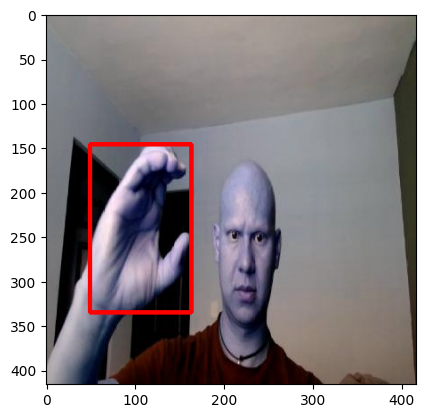

In [9]:
row_in = train_annotation.iloc[0]

img = cv2.imread(f'{folder_path}{row_in["image"]}')

xmin = int(row_in['xmin'])
xmax = int(row_in['xmax'])
ymin = int(row_in['ymin'])
ymax = int(row_in['ymax'])

img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=4)
plt.imshow(img)
plt.show()

In [10]:
folder_path_test = './Hand gestures dataset.v7-complete_v2_416x416.createml/test/'
list_test_img_names = os.listdir(folder_path_test)

In [11]:
# Поиск json файла, содержащего информацию о обучающих данных
dict_img_codes = {}
name_json_file = ''

for name_str in list_test_img_names:
    #print(name_str.split('.')[-1])
    file_ext = name_str.split('.')[-1]
    if file_ext == 'json':
        name_json_file = name_str
    else:
        list_name_str = name_str.split('.')[:-1]
        img_key = '.'.join(name_str.split('.')[:-1])
        dict_img_codes[img_key] = [img_key + '.jpg',
                                img_key + '.txt']

In [12]:
test_annotation = pd.read_json(folder_path_test + name_json_file)

In [13]:
# Редактирование данных
test_annotation['label'] = test_annotation['annotations'].apply(lambda x: x[0]['label'])
test_annotation['xc'] = test_annotation['annotations'].apply(lambda x: x[0]['coordinates']['x'])
test_annotation['yc'] = test_annotation['annotations'].apply(lambda x: x[0]['coordinates']['y'])
test_annotation['width'] = test_annotation['annotations'].apply(lambda x: x[0]['coordinates']['width'])
test_annotation['height'] = test_annotation['annotations'].apply(lambda x: x[0]['coordinates']['height'])

In [14]:
test_annotation.drop(columns=['annotations'], inplace=True)

In [15]:
test_annotation = test_annotation.astype({'xc': 'float', 'yc': 'float', 
                                            'width': 'float', 'height': 'float'})

In [16]:
test_annotation['xmin'] = (test_annotation['xc'] - test_annotation['width'] / 2)
test_annotation['xmax'] = (test_annotation['xc'] + test_annotation['width'] / 2)

test_annotation['ymin'] = (test_annotation['yc'] - test_annotation['height'] / 2)
test_annotation['ymax'] = (test_annotation['yc'] + test_annotation['height'] / 2)

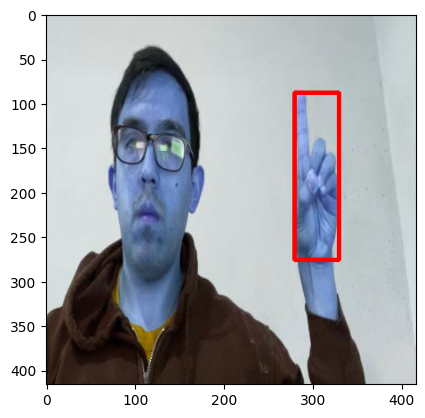

In [17]:
row_in = test_annotation.iloc[0]

img = cv2.imread(f'{folder_path_test}{row_in["image"]}')

xmin = int(row_in['xmin'])
xmax = int(row_in['xmax'])
ymin = int(row_in['ymin'])
ymax = int(row_in['ymax'])

img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=4)
plt.imshow(img)
plt.show()

In [18]:
species_labels = sorted(train_annotation['label'].unique())

Изображение всех жестов, содержащихся в наборе данных

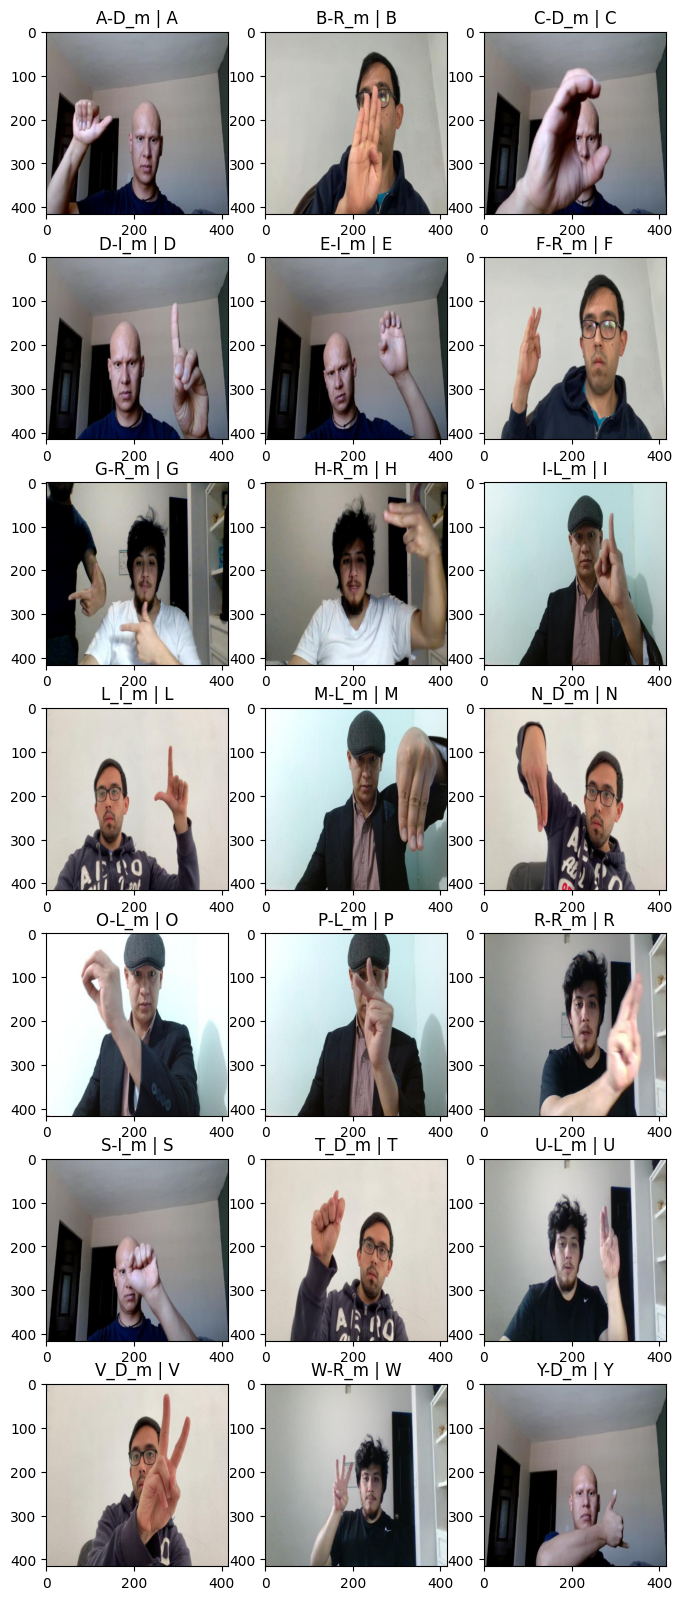

In [19]:
random_state = 42


fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(8, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    filtr = train_annotation['label'] == species
    img_file = train_annotation.loc[filtr, 'image'].sample(1, random_state=random_state).iloc[0]


    # reads the filepath and returns a numpy array
    img = mpimg.imread(folder_path + img_file)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_file[0:5]} | {species}")

In [20]:
train_annotation.groupby(by='label')['label'].count()

label
A    320
B    335
C    310
D    332
E    328
F    329
G    333
H    326
I    326
L    341
M    344
N    328
O    338
P    327
R    319
S    321
T    326
U    333
V    340
W    336
Y    336
Name: label, dtype: int64

In [21]:
#Доля жестов, принадлежащих каждому классу
img_number = train_annotation.shape[0]
train_annotation.groupby(by='label')['label'].count() / img_number

label
A    0.046189
B    0.048355
C    0.044746
D    0.047921
E    0.047344
F    0.047488
G    0.048066
H    0.047055
I    0.047055
L    0.049221
M    0.049654
N    0.047344
O    0.048788
P    0.047200
R    0.046045
S    0.046334
T    0.047055
U    0.048066
V    0.049076
W    0.048499
Y    0.048499
Name: label, dtype: float64

In [22]:
train_annotation['image']

0       C-D_mp4-28_jpg.rf.7dd960bce8ba5e68dfd98ac1b76e...
1       C-L_mp4-1_jpg.rf.7de949af56e038846790642c28404...
2       D-R_mp4-28_jpg.rf.7deb2e3f834735f434d44839ad94...
3       Y-L_mp4-64_jpg.rf.7dee61147a8952e4c7a3921f815d...
4       Y-R_mp4-59_jpg.rf.7e1b42cc76d1c015ee9ad7905906...
                              ...                        
6923    R-R_mp4-21_jpg.rf.f5ec0538014af55675d5771f591c...
6924    S_I_mov-17_jpg.rf.f62dc539bece2f317c328b0f0a5b...
6925    D-L_mp4-53_jpg.rf.f5e36734aef0a61668dc1b358055...
6926    N-L_mp4-14_jpg.rf.f646db5fa5e16e07d22a26c7da07...
6927    N_I_mov-12_jpg.rf.f5d07db9abe746dbe9ead57df21c...
Name: image, Length: 6928, dtype: object

In [23]:
df_train_dataset_classification = train_annotation['image'].to_frame()
df_train_dataset_classification[species_labels] = pd.get_dummies(train_annotation['label'])
df_train_dataset_classification.head(3)


,image,A,B,C,D,E,F,G,H,I,...,N,O,P,R,S,T,U,V,W,Y
0,C-D_mp4-28_jpg.rf.7dd960bce8ba5e68dfd98ac1b76e...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C-L_mp4-1_jpg.rf.7de949af56e038846790642c28404...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,D-R_mp4-28_jpg.rf.7deb2e3f834735f434d44839ad94...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_test_dataset_classification = test_annotation['image'].to_frame()
df_test_dataset_classification[species_labels] = pd.get_dummies(test_annotation['label'])
df_test_dataset_classification.head(3)

,image,A,B,C,D,E,F,G,H,I,...,N,O,P,R,S,T,U,V,W,Y
0,D-L_mov-38_jpg.rf.01d97bc7c62a958333bab73d4f55...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Y-I_mp4-44_jpg.rf.003a824a17fe3a73863505c72682...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,O-R_mp4-22_jpg.rf.0047a7f266f17d598b612497743b...,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
#Класс для формирования dataset
class ClassificationImagesDataset(Dataset):
    def __init__(self, data_info, folder_path):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1:].values
        self.data_len = self.data_info.shape[0]
        self.data_folder_path = folder_path

        self.preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                             std=[0.229, 0.224, 0.225]),
        ])


    def __getitem__(self, index):
        img = Image.open(self.data_folder_path + 
                         self.image_arr[index])
        input_batch = self.preprocess(img)
        
        
        label_batch = torch.tensor(self.label_arr[index], dtype=torch.float32)
        
        return (input_batch, label_batch)

    def __len__(self):
        return self.data_len

In [27]:
#dataloader для обучающих данных
train_data_classification = ClassificationImagesDataset(df_train_dataset_classification, folder_path=folder_path)
train_data_classification_loader = DataLoader(train_data_classification, batch_size=10, shuffle=True)

In [28]:
#dataloader для тестовых данных
test_data_classification = ClassificationImagesDataset(df_test_dataset_classification, folder_path=folder_path_test)
test_data_classification_loader = DataLoader(test_data_classification, batch_size=10, shuffle=False)

In [29]:
# Загрузка модели
model_classification = torchvision.models.mobilenet_v2(pretrained=True)
for param in model_classification.parameters():
    param.requires_grad = False

/Users/maxzhelnin/Conda_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxzhelnin/Conda_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
# Добавляем параметр расчета градиента для предпоследнего слоя
for param in model_classification.features[18].parameters():
    param.requires_grad = True

In [31]:
# Модифицируем последний полностью связный слой
model_classification.classifier = nn.Sequential(
    nn.Linear(1280, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(100, 21, bias=False)  # final dense layer
)

In [32]:
#Веса для оптимизации
params_to_update = []
for name,param in model_classification.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Количество весов для обучения
pytorch_total_params = sum(p.numel() for p in model_classification.parameters() if p.requires_grad)
pytorch_total_params

542360

In [35]:
optimizer = torch.optim.Adam(params_to_update, lr=5e-3)
loss_entropy = nn.CrossEntropyLoss()

In [36]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device = torch.device("mps")
print(device)

mps


In [37]:
model_classification = model_classification.to(device)

In [57]:
for epoch in range(10):
    # Печатаем отчёт каждую эпоху
    #   Считаем ошибку на тестовой выборке
    train_loss = 0
    test_loss = 0
    
    if epoch % 2 == 0:
        model_classification.eval()
        with torch.no_grad():
             #   Считаем ошибку на обучающей выборке
            for i, (X, y) in enumerate(train_data_classification_loader):
                X_gpu = X.to(device)
                y_gpu = y.to(device)
                y_pred = model_classification(X_gpu)
                #l_gpu = torchvision.ops.generalized_box_iou_loss(y_pred, y_gpu,
                  #                                                reduction='mean')
                l_gpu = loss_entropy(y_pred, y_gpu)
                # количество наблюдений может быть разным в разных батчах
                train_loss += l_gpu.to("cpu").item() * len(y)
            #   Считаем ошибку на тестовой выборке
            # for i, (X, y) in enumerate(test_data_classification_loader):
            #     X_gpu = X.to(device)
            #     y_gpu = y.to(device)
            #     y_pred = model_classification(X_gpu)
            #     l_gpu = loss_entropy(y_pred, y_gpu)
            #     # количество наблюдений может быть разным в разных батчах
            #     test_loss += l_gpu.to("cpu").item() * len(y)
        
        
            # torch.save(model.state_dict(), PATH_WEIGHTS+'resNet_model_val_loss'+str(val_loss)+'.pth')


        # print(epoch, " : ", 
        #      " train loss = ", train_loss / len(train_data_classification),
        #      " test_lost = ", test_loss / len(test_data_classification))

        print(epoch, " : ", 
             " train loss = ", train_loss / len(train_data_classification))

    
    model_classification.train()
    # Бежим по пакетам (batches)
    for i, (X, y) in enumerate(train_data_classification_loader):
        X_gpu = X.to(device)
        y_gpu = y.to(device)
        # Предсказание
        y_pred = model_classification(X_gpu)
        #l_gpu = torchvision.ops.generalized_box_iou_loss(y_pred, y_gpu,
        #                                                 reduction='mean')
        
        l_gpu = loss_entropy(y_pred, y_gpu)

        # Расчёт градиентов
        l_gpu.backward()

        # Оптимизация
        optimizer.step()
        # Зануляем градиент
        optimizer.zero_grad()

0  :   train loss =  0.021878636715348183
2  :   train loss =  0.019859536521529112
4  :   train loss =  0.01872676331210457
6  :   train loss =  0.017116890918081596
8  :   train loss =  0.009247180113236253


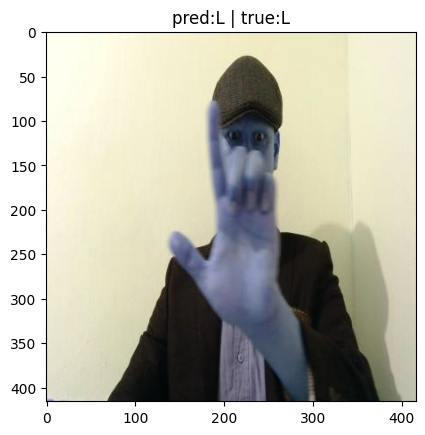

In [39]:
index = 390
row_in = df_train_dataset_classification.iloc[index]
row_index = row_in[1:].index
img_to_model = train_data_classification[index][0]

model_classification.eval()
with torch.no_grad():
    y_pred = model_classification(img_to_model.unsqueeze(0).to(device))
    probabilities = torch.nn.functional.softmax(y_pred[0], dim=0).to('cpu')
    label_id = int(torch.argmax(probabilities).numpy())

img = cv2.imread(f'{folder_path}{row_in["image"]}')

fig, ax1 = plt.subplots(1,1)
ax1.imshow(img)
ax1.set_title(f"pred:{species_labels[label_id]} | true:{row_index[row_in[1:] == 1][0]}")
plt.show()


Точность на обучающем dataset

In [40]:
acc_list = []
model_classification.eval()
with torch.no_grad(): 
    for i, (X, y) in enumerate(train_data_classification_loader):
        X_gpu = X.to(device)
        y_pred = model_classification(X_gpu)
        probabilities = torch.nn.functional.softmax(y_pred, dim=0).to('cpu')
        label_id_pred = torch.argmax(probabilities, dim=1).numpy()
        label_id_true = torch.argmax(y, dim=1).numpy()
        acc_list.append((label_id_pred == label_id_true))

ar_acc_list = np.concatenate(acc_list)
acc_train = ar_acc_list.sum() / ar_acc_list.size
print(f'accuracy train: {acc_train}')

accuracy train: 0.743215935334873


Точность на тестовом dataset

In [58]:
acc_list = []
model_classification.eval()
with torch.no_grad(): 
    for i, (X, y) in enumerate(test_data_classification_loader):
        X_gpu = X.to(device)
        y_pred = model_classification(X_gpu)
        probabilities = torch.nn.functional.softmax(y_pred, dim=0).to('cpu')
        label_id_pred = torch.argmax(probabilities, dim=1).numpy()
        label_id_true = torch.argmax(y, dim=1).numpy()
        acc_list.append((label_id_pred == label_id_true))

ar_acc_list = np.concatenate(acc_list)
acc_test = ar_acc_list.sum() / ar_acc_list.size
print(f'accuracy test: {acc_test}')

accuracy test: 0.7202072538860104


In [ ]:
# test_loss = 0
# model_classification.eval()
# with torch.no_grad():           
# #   Считаем ошибку на тестовой выборке
#     for i, (X, y) in enumerate(test_data_classification_loader):
#         X_gpu = X.to(device)
#         y_gpu = y.to(device)
#         y_pred = model_classification(X_gpu)
#         l_gpu = loss_entropy(y_pred, y_gpu)
#         # количество наблюдений может быть разным в разных батчах
#         test_loss += l_gpu.to("cpu").item() * len(y)

# print(" test loss = ", test_loss / len(test_data_classification_loader))

In [ ]:
index = 15
row_in = df_test_dataset_classification.iloc[index]
row_index = row_in[1:].index
img_to_model = test_data_classification[index][0]

model_classification.eval()
with torch.no_grad():
    y_pred = model_classification(img_to_model.unsqueeze(0).to(device))
    probabilities = torch.nn.functional.softmax(y_pred[0], dim=0).to('cpu')
    label_id = int(torch.argmax(probabilities).numpy())

img = cv2.imread(f'{folder_path_test}{row_in["image"]}')
fig, ax1 = plt.subplots(1,1)
ax1.imshow(img)
ax1.set_title(f"pred:{species_labels[label_id]} | true:{row_index[row_in[1:] == 1][0]}")
plt.show()

In [64]:
# Сохранение весов модели
PATH_WEIGHTS = './models_dict/'
model_dict_name = 'mobilenet_classification_20epoch'
torch.save(model_classification.to('cpu').state_dict(), PATH_WEIGHTS+model_dict_name+'.pth')

Проверка эффективности модели на собственных фотографиях

In [42]:
# Функция для преобразования фотографий
def transform_img_bbox(img_file_name_in:str, data_folder_path='./my_test_photo_resized/'):
    preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                             std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(data_folder_path + img_file_name_in)
    
    input_img = preprocess(img)
    return input_img

In [49]:
#folder_my_photo_test = './my_test_photo/'
#myphoto_img_list = os.listdir(folder_my_photo_test)

In [51]:
#folder_my_test_resized = './my_test_photo_resized/'
#img_file_name = myphoto_img_list[2]
#img = Image.open(folder_my_photo_test + img_file_name)
#new_image = img.resize((416, 416))
#new_image.save(folder_my_test_resized + img_file_name)

Считывание фотографии и распознавание жеста с помощью модели

In [52]:
folder_my_test_resized = './my_test_photo_resized/'
myphoto_img_list = os.listdir(folder_my_test_resized)

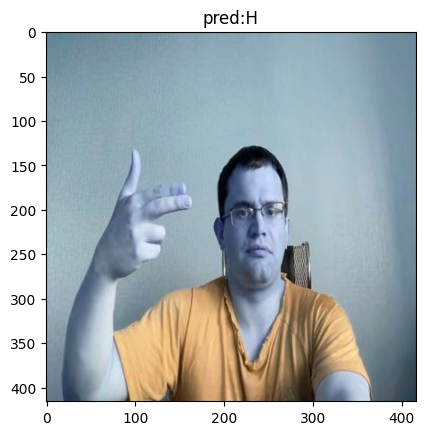

In [63]:
folder_my_test_resized = './my_test_photo_resized/'
img_file_name = myphoto_img_list[0]
img_to_model = transform_img_bbox(img_file_name, data_folder_path=folder_my_test_resized)
model_classification = model_classification.to(device)
model_classification.eval()
with torch.no_grad():
    y_pred = model_classification(img_to_model.unsqueeze(0).to(device))
    probabilities = torch.nn.functional.softmax(y_pred[0], dim=0).to('cpu')
    label_id = int(torch.argmax(probabilities).numpy())

img = cv2.imread(f'{folder_my_test_resized}{img_file_name}')
fig, ax1 = plt.subplots(1,1)
ax1.imshow(img)
ax1.set_title(f"pred:{species_labels[label_id]}")
plt.show()

Жест на фото определен верно!